# Set up for dataset and model

Package installation, loading, and dataloaders. There's also a resnet18 model defined.

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


# Dataloaders
train_dataset = datasets.CIFAR10('cifar10_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.CIFAR10('cifar10_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [2]:

def tp_relu(x, delta=1.):
    ind1 = (x < -1. * delta).float()
    ind2 = (x > delta).float()
    return .5 * (x + delta) * (1 - ind1) * (1 - ind2) + x * ind2

def tp_smoothed_relu(x, delta=1.):
    ind1 = (x < -1. * delta).float()
    ind2 = (x > delta).float()
    return (x + delta) ** 2 / (4 * delta) * (1 - ind1) * (1 - ind2) + x * ind2

class Normalize(nn.Module):
    def __init__(self, mu, std):
        super(Normalize, self).__init__()
        self.mu, self.std = mu, std

    def forward(self, x):
        return (x - self.mu) / self.std

class IdentityLayer(nn.Module):
    def forward(self, inputs):
        return inputs
    
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, bn, learnable_bn, stride=1, activation='relu'):
        super(PreActBlock, self).__init__()
        self.collect_preact = True
        self.activation = activation
        self.avg_preacts = []
        self.bn1 = nn.BatchNorm2d(in_planes, affine=learnable_bn) if bn else IdentityLayer()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=not learnable_bn)
        self.bn2 = nn.BatchNorm2d(planes, affine=learnable_bn) if bn else IdentityLayer()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=not learnable_bn)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=not learnable_bn)
            )

    def act_function(self, preact):
        if self.activation == 'relu':
            act = F.relu(preact)
        elif self.activation[:6] == '3prelu':
            act = tp_relu(preact, delta=float(self.activation.split('relu')[1]))
        elif self.activation[:8] == '3psmooth':
            act = tp_smoothed_relu(preact, delta=float(self.activation.split('smooth')[1]))
        else:
            assert self.activation[:8] == 'softplus'
            beta = int(self.activation.split('softplus')[1])
            act = F.softplus(preact, beta=beta)
        return act

    def forward(self, x):
        out = self.act_function(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x  # Important: using out instead of x
        out = self.conv1(out)
        out = self.conv2(self.act_function(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, n_cls, cuda=True, half_prec=False,
        activation='relu', fts_before_bn=False, normal='none'):
        super(PreActResNet, self).__init__()
        self.bn = True
        self.learnable_bn = True  # doesn't matter if self.bn=False
        self.in_planes = 64
        self.avg_preact = None
        self.activation = activation
        self.fts_before_bn = fts_before_bn
        if normal == 'cifar10':
            self.mu = torch.tensor((0.4914, 0.4822, 0.4465)).view(1, 3, 1, 1)
            self.std = torch.tensor((0.2471, 0.2435, 0.2616)).view(1, 3, 1, 1)
        else:
            self.mu = torch.tensor((0.0, 0.0, 0.0)).view(1, 3, 1, 1)
            self.std = torch.tensor((1.0, 1.0, 1.0)).view(1, 3, 1, 1)
            print('no input normalization')
        if cuda:
            self.mu = self.mu.cuda()
            self.std = self.std.cuda()
        if half_prec:
            self.mu = self.mu.half()
            self.std = self.std.half()

        self.normalize = Normalize(self.mu, self.std)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=not self.learnable_bn)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512*block.expansion, n_cls)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.bn, self.learnable_bn, stride, self.activation))
            # layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, return_features=False):
        for layer in [*self.layer1, *self.layer2, *self.layer3, *self.layer4]:
            layer.avg_preacts = []

        out = self.normalize(x)
        out = self.conv1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        if return_features and self.fts_before_bn:
            return out.view(out.size(0), -1)
        out = F.relu(self.bn(out))
        if return_features:
            return out.view(out.size(0), -1)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out


def PreActResNet18(n_cls, cuda=True, half_prec=False, activation='relu', fts_before_bn=False,
    normal='none'):
    #print('initializing PA RN-18 with act {}, normal {}'.format())
    return PreActResNet(PreActBlock, [2, 2, 2, 2], n_cls=n_cls, cuda=cuda, half_prec=half_prec,
        activation=activation, fts_before_bn=fts_before_bn, normal=normal)


# intialize the model
model = PreActResNet18(10, cuda=True, activation='softplus1').to(device)
model.eval()

no input normalization


PreActResNet(
  (normalize): Normalize()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBloc

# Standard Accuracy

In [3]:
def test_model_standard_accuracy(model):
    """Test model on clean (unperturbed) images"""
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (x_batch, y_batch) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating Standard Accuracy"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            output = model(x_batch)
            pred = torch.max(output, dim=1)[1]
            tot_acc += (pred == y_batch).sum().item()
            tot_test += y_batch.size(0)
    
    print('Standard accuracy %.5lf' % (tot_acc/tot_test))
    return tot_acc/tot_test

In [11]:
model.load_state_dict(torch.load('models/pretr_Linf.pth'))
test_model_standard_accuracy(model)

model.load_state_dict(torch.load('models/pretr_L2.pth'))
test_model_standard_accuracy(model)

model.load_state_dict(torch.load('models/pretr_RAMP.pth'))
test_model_standard_accuracy(model)


/tmp/ipykernel_675717/3615808324.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/pretr_Linf.pth'))
Evaluating Standard Accuracy:

Standard accuracy 0.82800


Evaluating Standard Accuracy: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 102.67it/s]
/tmp/ipykernel_675717/3615808324.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for a

Standard accuracy 0.88750


Evaluating Standard Accuracy: 100%|███████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 103.02it/s]

Standard accuracy 0.81190


0.8119

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [4]:
def pgd_linf_untargeted(model, x, labels, k, eps, eps_step):
    model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 
    for _ in range(k):
        adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)
        loss = ce_loss(output, labels)
        loss.backward()
        # compute the adv_x
        # find delta, clamp with eps
        grad = adv_x.grad.data
        adv_x = adv_x.detach() + eps_step * grad.sign()
        
        delta = torch.clamp(adv_x - x, min=-eps, max=eps)
        adv_x = torch.clamp(x + delta, min=0, max=1)
   
    return adv_x

In [5]:
def pgd_l2_untargeted(model, x, labels, k, eps, eps_step):
    model.eval()
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 
    for _ in range(k):
        adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)
        batch_size = x.size()[0]
        # Calculate the loss
        loss = ce_loss(output, labels)
        loss.backward()
        grad = adv_x.grad.data

        # compute the adv_x
        # find delta, clamp with eps, project delta to the l2 ball
        # HINT: https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/torchattacks/attacks/pgdl2.py 
        grad_norm = torch.norm(grad.view(batch_size, -1), dim=1, keepdim=True).view(-1, 1, 1, 1)
        grad_normalized = grad / (grad_norm + 1e-8)
        adv_x = adv_x.detach() + eps_step * grad_normalized
        
        delta = adv_x - x
        delta_norm = torch.norm(delta.view(batch_size, -1), dim=1, keepdim=True).view(-1, 1, 1, 1)
        delta = delta * eps / torch.max(delta_norm, eps * torch.ones_like(delta_norm))
        adv_x = torch.clamp(x + delta, min=0, max=1)
   
    return adv_x

# Evaluate Single and Multi-Norm Robust Accuracy

In this section, we evaluate the model on the Linf and L2 attacks as well as union accuracy.

In [6]:
def test_model_on_single_attack(model, attack='pgd_linf', eps=0.1):
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        if attack == 'pgd_linf':
            # get x_adv untargeted pgd linf with eps, and eps_step=eps/4
            x_adv = pgd_linf_untargeted(model, x_batch, y_batch, k=20, eps=eps, eps_step=eps/4)
        elif attack == 'pgd_l2':
            # get x_adv untargeted pgd l2 with eps, and eps_step=eps/4
            x_adv = pgd_l2_untargeted(model, x_batch, y_batch, k=20, eps=eps, eps_step=eps/4)
        else:
            pass
        
        # get the testing accuracy and update tot_test and tot_acc
        output = model(x_adv)
        pred = torch.max(output, dim=1)[1]
        tot_acc += (pred == y_batch).sum().item()
        tot_test += y_batch.size(0)
            
    print('Robust accuracy %.5lf' % (tot_acc/tot_test), f'on {attack} attack with eps = {eps}')

## Single-Norm Robust Accuracy

In [6]:
# Evaluate on Linf attack with different models with eps = 8/255
model.load_state_dict(torch.load('models/pretr_Linf.pth'))
# Evaluate on Linf attack with model 1 with eps = 8/255
test_model_on_single_attack(model, attack='pgd_linf', eps=8./255.)

model.load_state_dict(torch.load('models/pretr_L2.pth'))
# Evaluate on Linf attack with model 2 with eps = 8/255
test_model_on_single_attack(model, attack='pgd_linf', eps=8./255.)

model.load_state_dict(torch.load('models/pretr_RAMP.pth'))
# Evaluate on Linf attack with model 3 with eps = 8/255
test_model_on_single_attack(model, attack='pgd_linf', eps=8./255.)

/tmp/ipykernel_675717/3797553474.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/pretr_Linf.pth'))
Evaluating: 100%|████████████

Robust accuracy 0.50760 on pgd_linf attack with eps = 0.03137254901960784


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:51<00:00,  3.06it/s]
/tmp/ipykernel_675717/3797553474.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for 

Robust accuracy 0.29470 on pgd_linf attack with eps = 0.03137254901960784


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:51<00:00,  3.07it/s]

Robust accuracy 0.49040 on pgd_linf attack with eps = 0.03137254901960784


In [7]:
# Evaluate on L2 attack with different models with eps = 0.75
model.load_state_dict(torch.load('models/pretr_Linf.pth'))
# Evaluate on Linf attack with model 1 with eps = 0.75
test_model_on_single_attack(model, attack='pgd_l2', eps=0.75)

model.load_state_dict(torch.load('models/pretr_L2.pth'))
# Evaluate on Linf attack with model 2 with eps = 0.75
test_model_on_single_attack(model, attack='pgd_l2', eps=0.75)

model.load_state_dict(torch.load('models/pretr_RAMP.pth'))
# Evaluate on Linf attack with model 3 with eps = 0.75
test_model_on_single_attack(model, attack='pgd_l2', eps=0.75)

/tmp/ipykernel_675717/2225722726.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/pretr_Linf.pth'))
Evaluating: 100%|████████████

Robust accuracy 0.47020 on pgd_l2 attack with eps = 0.75


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:50<00:00,  3.08it/s]
/tmp/ipykernel_675717/2225722726.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for 

Robust accuracy 0.53580 on pgd_l2 attack with eps = 0.75


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:50<00:00,  3.09it/s]

Robust accuracy 0.59370 on pgd_l2 attack with eps = 0.75


## Multi-Norm Robust Accuracy

In [7]:
def test_model_on_multi_attacks(model, eps_linf=8./255., eps_l2=0.75):
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # get x_adv_linf and x_adv_l2 untargeted pgd linf and l2 with eps, and eps_step=eps/4
        x_adv_linf = pgd_linf_untargeted(model, x_batch, y_batch, k=20, eps=eps_linf, eps_step=eps_linf/4)
        x_adv_l2 = pgd_l2_untargeted(model, x_batch, y_batch, k=20, eps=eps_l2, eps_step=eps_l2/4)
        
        ## calculate union accuracy: correct only if both attacks are correct
        
        out = model(x_adv_linf)
        pred_linf = torch.max(out, dim=1)[1]
        out = model(x_adv_l2)
        pred_l2 = torch.max(out, dim=1)[1]
        
        # get the testing accuracy with multi-norm robustness and update tot_test and tot_acc
        tot_acc += ((pred_linf == y_batch) & (pred_l2 == y_batch)).sum().item()
        tot_test += y_batch.size(0)
            
    print('Robust accuracy %.5lf' % (tot_acc/tot_test), f'on multi attacks')

In [9]:
# Evaluate on multi-norm attacks with different models with eps_linf = 8./255, eps_l2 = 0.75
model.load_state_dict(torch.load('models/pretr_Linf.pth'))
# Evaluate on multi attacks with model 1
test_model_on_multi_attacks(model, eps_linf=8./255., eps_l2=0.75)

model.load_state_dict(torch.load('models/pretr_L2.pth'))
# Evaluate on multi attacks with model 2
test_model_on_multi_attacks(model, eps_linf=8./255., eps_l2=0.75)

model.load_state_dict(torch.load('models/pretr_RAMP.pth'))
# Evaluate on multi attacks with model 3
test_model_on_multi_attacks(model, eps_linf=8./255., eps_l2=0.75)

/tmp/ipykernel_675717/2844882111.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/pretr_Linf.pth'))
Evaluating: 100%|████████████

Robust accuracy 0.45530 on multi attacks


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:40<00:00,  1.56it/s]
/tmp/ipykernel_675717/2844882111.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for 

Robust accuracy 0.29470 on multi attacks


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:40<00:00,  1.56it/s]

Robust accuracy 0.49030 on multi attacks


## HW3 Problem 1

In [8]:
# Adversarial training function
def adversarial_training(model, train_loader, test_loader, epochs=100, 
                        attack_type='pgd_linf', eps=8./255., eps_step=2./255., 
                        attack_iters=7, lr=0.01):
    """
    Perform adversarial training on the model.
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        test_loader: Test data loader
        epochs: Number of training epochs
        attack_type: Type of attack ('pgd_linf' or 'pgd_l2')
        eps: Perturbation budget
        eps_step: Step size for PGD
        attack_iters: Number of PGD iterations
        lr: Learning rate for optimizer
    """
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1)
    ce_loss = nn.CrossEntropyLoss()
    
    training_history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'robust_acc': []
    }
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (x_batch, y_batch) in enumerate(pbar):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Generate adversarial examples
            model.eval()  # Set to eval mode for generating adversarial examples
            if attack_type == 'pgd_linf':
                x_adv = pgd_linf_untargeted(model, x_batch, y_batch, 
                                           k=attack_iters, eps=eps, eps_step=eps_step)
            elif attack_type == 'pgd_l2':
                x_adv = pgd_l2_untargeted(model, x_batch, y_batch, 
                                         k=attack_iters, eps=eps, eps_step=eps_step)
            else:
                raise ValueError(f"Unknown attack type: {attack_type}")
            
            # Train on adversarial examples
            model.train()
            optimizer.zero_grad()
            output = model(x_adv)
            loss = ce_loss(output, y_batch)
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            pred = output.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)
            total_loss += loss.item()
            
            pbar.set_postfix({
                'loss': f'{total_loss/(batch_idx+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        scheduler.step()
        
        # Record training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        
        # Evaluate on test set (using your existing function)
        test_acc = test_model_standard_accuracy(model)
        
        # Evaluate robust accuracy
        model.eval()
        tot_test, tot_acc = 0.0, 0.0
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if attack_type == 'pgd_linf':
                x_adv = pgd_linf_untargeted(model, x_batch, y_batch, k=20, eps=eps, eps_step=eps/4)
            else:
                x_adv = pgd_l2_untargeted(model, x_batch, y_batch, k=20, eps=eps, eps_step=eps/4)
            output = model(x_adv)
            pred = torch.max(output, dim=1)[1]
            tot_acc += (pred == y_batch).sum().item()
            tot_test += y_batch.size(0)
        robust_acc = tot_acc / tot_test
        
        training_history['test_acc'].append(test_acc)
        training_history['robust_acc'].append(robust_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
              f'Train Acc: {100*train_acc:.2f}%, '
              f'Test Acc: {100*test_acc:.2f}%, '
              f'Robust Acc: {100*robust_acc:.2f}%')
    
    return training_history

### Part (a)

In [10]:
# Experiment 1: L-infinity adversarial training with eps = 8/255
print("Experiment 1: L-infinity adversarial training (eps = 8/255)")
model_adv_linf_8 = PreActResNet18(10, cuda=True, activation='softplus1').to(device)
history_linf_8 = adversarial_training(
    model_adv_linf_8, train_loader, test_loader,
    epochs=100,
    attack_type='pgd_linf',
    eps=8./255.,
    eps_step=2./255.,
    attack_iters=7,
    lr=0.1
)

# Save the model
torch.save(model_adv_linf_8.state_dict(), 'adv_trained_linf_8.pth')

# Final evaluation
print("\nFinal Evaluation for L-infinity (eps=8/255) model")
test_model_standard_accuracy(model_adv_linf_8)
test_model_on_single_attack(model_adv_linf_8, attack='pgd_linf', eps=8./255.)
test_model_on_single_attack(model_adv_linf_8, attack='pgd_l2', eps=0.75)

Experiment 1: L-infinity adversarial training (eps = 8/255)
no input normalization


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.87it/s]


Standard accuracy 0.31590
Epoch 1: Train Loss: 2.1189, Train Acc: 21.53%, Test Acc: 31.59%, Robust Acc: 19.45%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.72it/s]


Standard accuracy 0.36990
Epoch 2: Train Loss: 1.9734, Train Acc: 26.05%, Test Acc: 36.99%, Robust Acc: 24.12%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.48it/s]


Standard accuracy 0.38470
Epoch 3: Train Loss: 1.9265, Train Acc: 28.30%, Test Acc: 38.47%, Robust Acc: 25.42%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.41it/s]


Standard accuracy 0.37990
Epoch 4: Train Loss: 1.8934, Train Acc: 29.61%, Test Acc: 37.99%, Robust Acc: 26.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 101.23it/s]


Standard accuracy 0.21240
Epoch 5: Train Loss: 1.8704, Train Acc: 30.39%, Test Acc: 21.24%, Robust Acc: 15.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.45it/s]


Standard accuracy 0.32790
Epoch 6: Train Loss: 1.8490, Train Acc: 31.47%, Test Acc: 32.79%, Robust Acc: 22.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.68it/s]


Standard accuracy 0.34290
Epoch 7: Train Loss: 1.8119, Train Acc: 32.87%, Test Acc: 34.29%, Robust Acc: 21.42%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.44it/s]


Standard accuracy 0.40730
Epoch 8: Train Loss: 1.7982, Train Acc: 33.13%, Test Acc: 40.73%, Robust Acc: 26.02%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.88it/s]


Standard accuracy 0.38420
Epoch 9: Train Loss: 1.7748, Train Acc: 34.11%, Test Acc: 38.42%, Robust Acc: 24.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.66it/s]


Standard accuracy 0.31900
Epoch 10: Train Loss: 1.7581, Train Acc: 35.11%, Test Acc: 31.90%, Robust Acc: 18.28%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.60it/s]


Standard accuracy 0.20020
Epoch 11: Train Loss: 1.7545, Train Acc: 34.74%, Test Acc: 20.02%, Robust Acc: 12.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.21it/s]


Standard accuracy 0.37420
Epoch 12: Train Loss: 1.7428, Train Acc: 35.40%, Test Acc: 37.42%, Robust Acc: 21.13%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.57it/s]


Standard accuracy 0.41180
Epoch 13: Train Loss: 1.7293, Train Acc: 36.03%, Test Acc: 41.18%, Robust Acc: 25.21%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.49it/s]


Standard accuracy 0.34320
Epoch 14: Train Loss: 1.7245, Train Acc: 35.87%, Test Acc: 34.32%, Robust Acc: 23.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.39it/s]


Standard accuracy 0.22230
Epoch 15: Train Loss: 1.7128, Train Acc: 36.46%, Test Acc: 22.23%, Robust Acc: 13.59%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.65it/s]


Standard accuracy 0.46520
Epoch 16: Train Loss: 1.7095, Train Acc: 36.49%, Test Acc: 46.52%, Robust Acc: 26.08%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.35it/s]


Standard accuracy 0.25740
Epoch 17: Train Loss: 1.6945, Train Acc: 37.25%, Test Acc: 25.74%, Robust Acc: 14.10%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.31it/s]


Standard accuracy 0.43610
Epoch 18: Train Loss: 1.6855, Train Acc: 37.53%, Test Acc: 43.61%, Robust Acc: 22.74%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.70it/s]


Standard accuracy 0.48990
Epoch 19: Train Loss: 1.6808, Train Acc: 37.63%, Test Acc: 48.99%, Robust Acc: 22.53%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.23it/s]


Standard accuracy 0.47420
Epoch 20: Train Loss: 1.6693, Train Acc: 38.10%, Test Acc: 47.42%, Robust Acc: 28.17%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Standard accuracy 0.43680
Epoch 21: Train Loss: 1.6704, Train Acc: 38.17%, Test Acc: 43.68%, Robust Acc: 23.71%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.65it/s]


Standard accuracy 0.50120
Epoch 22: Train Loss: 1.6589, Train Acc: 39.04%, Test Acc: 50.12%, Robust Acc: 25.99%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.55it/s]


Standard accuracy 0.38070
Epoch 23: Train Loss: 1.6685, Train Acc: 38.22%, Test Acc: 38.07%, Robust Acc: 21.90%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.41it/s]


Standard accuracy 0.39130
Epoch 24: Train Loss: 1.6603, Train Acc: 38.40%, Test Acc: 39.13%, Robust Acc: 22.58%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.49it/s]


Standard accuracy 0.32170
Epoch 25: Train Loss: 1.6516, Train Acc: 38.63%, Test Acc: 32.17%, Robust Acc: 18.16%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.30it/s]


Standard accuracy 0.41060
Epoch 26: Train Loss: 1.6441, Train Acc: 39.40%, Test Acc: 41.06%, Robust Acc: 24.12%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.00it/s]


Standard accuracy 0.10000
Epoch 27: Train Loss: 1.6420, Train Acc: 39.16%, Test Acc: 10.00%, Robust Acc: 10.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.90it/s]


Standard accuracy 0.28290
Epoch 28: Train Loss: 1.6495, Train Acc: 38.63%, Test Acc: 28.29%, Robust Acc: 16.46%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.76it/s]


Standard accuracy 0.36150
Epoch 29: Train Loss: 1.6417, Train Acc: 39.17%, Test Acc: 36.15%, Robust Acc: 22.17%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.23it/s]


Standard accuracy 0.44260
Epoch 30: Train Loss: 1.6390, Train Acc: 39.60%, Test Acc: 44.26%, Robust Acc: 25.56%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.95it/s]


Standard accuracy 0.39120
Epoch 31: Train Loss: 1.6416, Train Acc: 38.88%, Test Acc: 39.12%, Robust Acc: 22.44%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.84it/s]


Standard accuracy 0.43640
Epoch 32: Train Loss: 1.6345, Train Acc: 39.58%, Test Acc: 43.64%, Robust Acc: 25.22%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.13it/s]


Standard accuracy 0.44970
Epoch 33: Train Loss: 1.6419, Train Acc: 39.24%, Test Acc: 44.97%, Robust Acc: 26.73%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 93.82it/s]


Standard accuracy 0.13620
Epoch 34: Train Loss: 1.6385, Train Acc: 39.44%, Test Acc: 13.62%, Robust Acc: 10.32%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.00it/s]


Standard accuracy 0.36530
Epoch 35: Train Loss: 1.6359, Train Acc: 39.36%, Test Acc: 36.53%, Robust Acc: 22.30%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.36it/s]


Standard accuracy 0.18990
Epoch 36: Train Loss: 1.6181, Train Acc: 40.21%, Test Acc: 18.99%, Robust Acc: 10.51%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.65it/s]


Standard accuracy 0.37940
Epoch 37: Train Loss: 1.6288, Train Acc: 39.84%, Test Acc: 37.94%, Robust Acc: 23.61%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.13it/s]


Standard accuracy 0.26240
Epoch 38: Train Loss: 1.6277, Train Acc: 39.83%, Test Acc: 26.24%, Robust Acc: 13.55%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.21it/s]


Standard accuracy 0.39950
Epoch 39: Train Loss: 1.6209, Train Acc: 40.37%, Test Acc: 39.95%, Robust Acc: 24.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.35it/s]


Standard accuracy 0.26010
Epoch 40: Train Loss: 1.6191, Train Acc: 40.19%, Test Acc: 26.01%, Robust Acc: 13.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.42it/s]


Standard accuracy 0.41430
Epoch 41: Train Loss: 1.6175, Train Acc: 40.56%, Test Acc: 41.43%, Robust Acc: 23.14%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.70it/s]


Standard accuracy 0.52490
Epoch 42: Train Loss: 1.6260, Train Acc: 39.97%, Test Acc: 52.49%, Robust Acc: 30.74%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.61it/s]


Standard accuracy 0.43580
Epoch 43: Train Loss: 1.6093, Train Acc: 40.65%, Test Acc: 43.58%, Robust Acc: 24.18%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.80it/s]


Standard accuracy 0.42430
Epoch 44: Train Loss: 1.6184, Train Acc: 40.33%, Test Acc: 42.43%, Robust Acc: 26.39%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.65it/s]


Standard accuracy 0.37770
Epoch 45: Train Loss: 1.6115, Train Acc: 40.80%, Test Acc: 37.77%, Robust Acc: 19.23%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 62.66it/s]


Standard accuracy 0.33910
Epoch 46: Train Loss: 1.6140, Train Acc: 40.44%, Test Acc: 33.91%, Robust Acc: 17.50%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 63.16it/s]


Standard accuracy 0.43260
Epoch 47: Train Loss: 1.6154, Train Acc: 40.35%, Test Acc: 43.26%, Robust Acc: 24.18%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.93it/s]


Standard accuracy 0.39720
Epoch 48: Train Loss: 1.6099, Train Acc: 40.61%, Test Acc: 39.72%, Robust Acc: 21.49%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.42it/s]


Standard accuracy 0.37440
Epoch 49: Train Loss: 1.6082, Train Acc: 40.88%, Test Acc: 37.44%, Robust Acc: 20.72%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.54it/s]


Standard accuracy 0.53110
Epoch 50: Train Loss: 1.6142, Train Acc: 40.43%, Test Acc: 53.11%, Robust Acc: 28.56%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.64it/s]


Standard accuracy 0.65590
Epoch 51: Train Loss: 1.5769, Train Acc: 40.21%, Test Acc: 65.59%, Robust Acc: 39.29%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 64.04it/s]


Standard accuracy 0.66730
Epoch 52: Train Loss: 1.5473, Train Acc: 41.45%, Test Acc: 66.73%, Robust Acc: 39.38%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 65.31it/s]


Standard accuracy 0.65400
Epoch 53: Train Loss: 1.5338, Train Acc: 41.95%, Test Acc: 65.40%, Robust Acc: 39.14%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.66it/s]


Standard accuracy 0.66410
Epoch 54: Train Loss: 1.5234, Train Acc: 42.62%, Test Acc: 66.41%, Robust Acc: 39.06%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.50it/s]


Standard accuracy 0.65910
Epoch 55: Train Loss: 1.5152, Train Acc: 42.97%, Test Acc: 65.91%, Robust Acc: 39.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.52it/s]


Standard accuracy 0.60170
Epoch 56: Train Loss: 1.5094, Train Acc: 43.26%, Test Acc: 60.17%, Robust Acc: 35.24%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.44it/s]


Standard accuracy 0.59640
Epoch 57: Train Loss: 1.5026, Train Acc: 43.47%, Test Acc: 59.64%, Robust Acc: 34.89%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.57it/s]


Standard accuracy 0.61480
Epoch 58: Train Loss: 1.4969, Train Acc: 43.58%, Test Acc: 61.48%, Robust Acc: 34.45%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Standard accuracy 0.60580
Epoch 59: Train Loss: 1.4919, Train Acc: 43.99%, Test Acc: 60.58%, Robust Acc: 34.13%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.45it/s]


Standard accuracy 0.60900
Epoch 60: Train Loss: 1.4893, Train Acc: 43.96%, Test Acc: 60.90%, Robust Acc: 34.31%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.54it/s]


Standard accuracy 0.62100
Epoch 61: Train Loss: 1.4803, Train Acc: 44.73%, Test Acc: 62.10%, Robust Acc: 38.01%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.55it/s]


Standard accuracy 0.63170
Epoch 62: Train Loss: 1.4787, Train Acc: 44.47%, Test Acc: 63.17%, Robust Acc: 37.47%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.58it/s]


Standard accuracy 0.64140
Epoch 63: Train Loss: 1.4728, Train Acc: 45.01%, Test Acc: 64.14%, Robust Acc: 36.08%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.37it/s]


Standard accuracy 0.62050
Epoch 64: Train Loss: 1.4722, Train Acc: 44.77%, Test Acc: 62.05%, Robust Acc: 34.55%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.54it/s]


Standard accuracy 0.62660
Epoch 65: Train Loss: 1.4642, Train Acc: 45.58%, Test Acc: 62.66%, Robust Acc: 37.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.72it/s]


Standard accuracy 0.62780
Epoch 66: Train Loss: 1.4633, Train Acc: 45.35%, Test Acc: 62.78%, Robust Acc: 35.59%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.51it/s]


Standard accuracy 0.55440
Epoch 67: Train Loss: 1.4586, Train Acc: 45.51%, Test Acc: 55.44%, Robust Acc: 30.74%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.32it/s]


Standard accuracy 0.55110
Epoch 68: Train Loss: 1.4549, Train Acc: 45.82%, Test Acc: 55.11%, Robust Acc: 30.78%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.47it/s]


Standard accuracy 0.54900
Epoch 69: Train Loss: 1.4583, Train Acc: 45.62%, Test Acc: 54.90%, Robust Acc: 31.61%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.66it/s]


Standard accuracy 0.59520
Epoch 70: Train Loss: 1.4537, Train Acc: 45.85%, Test Acc: 59.52%, Robust Acc: 34.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.54it/s]


Standard accuracy 0.61950
Epoch 71: Train Loss: 1.4478, Train Acc: 45.99%, Test Acc: 61.95%, Robust Acc: 32.59%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.44it/s]


Standard accuracy 0.51670
Epoch 72: Train Loss: 1.4444, Train Acc: 46.15%, Test Acc: 51.67%, Robust Acc: 29.69%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.49it/s]


Standard accuracy 0.56180
Epoch 73: Train Loss: 1.4436, Train Acc: 46.02%, Test Acc: 56.18%, Robust Acc: 29.39%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.73it/s]


Standard accuracy 0.65620
Epoch 74: Train Loss: 1.4391, Train Acc: 46.26%, Test Acc: 65.62%, Robust Acc: 34.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.52it/s]


Standard accuracy 0.59960
Epoch 75: Train Loss: 1.4419, Train Acc: 46.06%, Test Acc: 59.96%, Robust Acc: 34.79%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.63it/s]


Standard accuracy 0.55280
Epoch 76: Train Loss: 1.4355, Train Acc: 46.63%, Test Acc: 55.28%, Robust Acc: 31.01%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.60it/s]


Standard accuracy 0.63020
Epoch 77: Train Loss: 1.4342, Train Acc: 46.53%, Test Acc: 63.02%, Robust Acc: 35.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.65it/s]


Standard accuracy 0.61740
Epoch 78: Train Loss: 1.4347, Train Acc: 46.45%, Test Acc: 61.74%, Robust Acc: 35.10%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.73it/s]


Standard accuracy 0.55620
Epoch 79: Train Loss: 1.4296, Train Acc: 46.61%, Test Acc: 55.62%, Robust Acc: 29.14%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.58it/s]


Standard accuracy 0.62930
Epoch 80: Train Loss: 1.4227, Train Acc: 46.90%, Test Acc: 62.93%, Robust Acc: 36.48%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.60it/s]


Standard accuracy 0.71370
Epoch 81: Train Loss: 1.4121, Train Acc: 46.08%, Test Acc: 71.37%, Robust Acc: 42.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.57it/s]


Standard accuracy 0.71030
Epoch 82: Train Loss: 1.3979, Train Acc: 46.71%, Test Acc: 71.03%, Robust Acc: 42.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.48it/s]


Standard accuracy 0.71170
Epoch 83: Train Loss: 1.3910, Train Acc: 47.22%, Test Acc: 71.17%, Robust Acc: 42.45%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.59it/s]


Standard accuracy 0.69480
Epoch 84: Train Loss: 1.3862, Train Acc: 47.31%, Test Acc: 69.48%, Robust Acc: 42.32%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.51it/s]


Standard accuracy 0.71580
Epoch 85: Train Loss: 1.3847, Train Acc: 47.49%, Test Acc: 71.58%, Robust Acc: 42.36%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.57it/s]


Standard accuracy 0.71940
Epoch 86: Train Loss: 1.3808, Train Acc: 47.51%, Test Acc: 71.94%, Robust Acc: 42.40%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.36it/s]


Standard accuracy 0.71750
Epoch 87: Train Loss: 1.3800, Train Acc: 47.50%, Test Acc: 71.75%, Robust Acc: 42.75%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.37it/s]


Standard accuracy 0.70660
Epoch 88: Train Loss: 1.3760, Train Acc: 47.74%, Test Acc: 70.66%, Robust Acc: 42.33%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.54it/s]


Standard accuracy 0.72110
Epoch 89: Train Loss: 1.3720, Train Acc: 47.70%, Test Acc: 72.11%, Robust Acc: 42.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.24it/s]


Standard accuracy 0.71620
Epoch 90: Train Loss: 1.3731, Train Acc: 47.79%, Test Acc: 71.62%, Robust Acc: 42.10%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.64it/s]


Standard accuracy 0.71600
Epoch 91: Train Loss: 1.3713, Train Acc: 48.14%, Test Acc: 71.60%, Robust Acc: 42.49%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.35it/s]


Standard accuracy 0.70220
Epoch 92: Train Loss: 1.3687, Train Acc: 48.14%, Test Acc: 70.22%, Robust Acc: 42.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.60it/s]


Standard accuracy 0.72410
Epoch 93: Train Loss: 1.3682, Train Acc: 48.11%, Test Acc: 72.41%, Robust Acc: 42.23%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.48it/s]


Standard accuracy 0.71680
Epoch 94: Train Loss: 1.3657, Train Acc: 48.04%, Test Acc: 71.68%, Robust Acc: 42.02%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.49it/s]


Standard accuracy 0.71540
Epoch 95: Train Loss: 1.3633, Train Acc: 48.31%, Test Acc: 71.54%, Robust Acc: 42.26%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.19it/s]


Standard accuracy 0.71300
Epoch 96: Train Loss: 1.3626, Train Acc: 48.12%, Test Acc: 71.30%, Robust Acc: 42.77%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.58it/s]


Standard accuracy 0.71940
Epoch 97: Train Loss: 1.3618, Train Acc: 48.27%, Test Acc: 71.94%, Robust Acc: 42.91%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Standard accuracy 0.71870
Epoch 98: Train Loss: 1.3601, Train Acc: 48.47%, Test Acc: 71.87%, Robust Acc: 41.69%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.26it/s]


Standard accuracy 0.72300
Epoch 99: Train Loss: 1.3560, Train Acc: 48.62%, Test Acc: 72.30%, Robust Acc: 41.61%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Standard accuracy 0.71380
Epoch 100: Train Loss: 1.3571, Train Acc: 48.45%, Test Acc: 71.38%, Robust Acc: 42.84%

Final Evaluation for L-infinity (eps=8/255) model


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.19it/s]


Standard accuracy 0.71380


Evaluating: 100%|██████████| 157/157 [01:24<00:00,  1.85it/s]


Robust accuracy 0.42840 on pgd_linf attack with eps = 0.03137254901960784


Evaluating: 100%|██████████| 157/157 [01:25<00:00,  1.83it/s]

Robust accuracy 0.46330 on pgd_l2 attack with eps = 0.75


In [11]:
# Experiment 2: L-infinity adversarial training with eps = 4/255
print("Experiment 2: L-infinity adversarial training (eps = 4/255)")
model_adv_linf_4 = PreActResNet18(10, cuda=True, activation='softplus1').to(device)
history_linf_4 = adversarial_training(
    model_adv_linf_4, train_loader, test_loader,
    epochs=100,
    attack_type='pgd_linf',
    eps=4./255.,
    eps_step=1./255.,
    attack_iters=7,
    lr=0.1
)

torch.save(model_adv_linf_4.state_dict(), 'adv_trained_linf_4.pth')

print("\nFinal Evaluation for L-infinity (eps=4/255) model")
test_model_standard_accuracy(model_adv_linf_4)
test_model_on_single_attack(model_adv_linf_4, attack='pgd_linf', eps=4./255.)
test_model_on_single_attack(model_adv_linf_4, attack='pgd_linf', eps=8./255.)

Experiment 2: L-infinity adversarial training (eps = 4/255)
no input normalization


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.72it/s]


Standard accuracy 0.39720
Epoch 1: Train Loss: 1.9422, Train Acc: 27.71%, Test Acc: 39.72%, Robust Acc: 31.06%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.68it/s]


Standard accuracy 0.32630
Epoch 2: Train Loss: 1.7445, Train Acc: 34.38%, Test Acc: 32.63%, Robust Acc: 25.49%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.87it/s]


Standard accuracy 0.38080
Epoch 3: Train Loss: 1.6556, Train Acc: 38.18%, Test Acc: 38.08%, Robust Acc: 27.68%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.24it/s]


Standard accuracy 0.33890
Epoch 4: Train Loss: 1.6005, Train Acc: 40.85%, Test Acc: 33.89%, Robust Acc: 25.64%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.55it/s]


Standard accuracy 0.30030
Epoch 5: Train Loss: 1.5500, Train Acc: 42.65%, Test Acc: 30.03%, Robust Acc: 21.86%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.64it/s]


Standard accuracy 0.41490
Epoch 6: Train Loss: 1.5028, Train Acc: 44.42%, Test Acc: 41.49%, Robust Acc: 29.36%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.45it/s]


Standard accuracy 0.18330
Epoch 7: Train Loss: 1.4659, Train Acc: 45.87%, Test Acc: 18.33%, Robust Acc: 13.23%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.71it/s]


Standard accuracy 0.41710
Epoch 8: Train Loss: 1.4305, Train Acc: 47.27%, Test Acc: 41.71%, Robust Acc: 25.08%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.35it/s]


Standard accuracy 0.44450
Epoch 9: Train Loss: 1.4108, Train Acc: 47.79%, Test Acc: 44.45%, Robust Acc: 28.23%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.34it/s]


Standard accuracy 0.19480
Epoch 10: Train Loss: 1.3899, Train Acc: 48.78%, Test Acc: 19.48%, Robust Acc: 14.65%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.54it/s]


Standard accuracy 0.44060
Epoch 11: Train Loss: 1.3717, Train Acc: 49.65%, Test Acc: 44.06%, Robust Acc: 31.26%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.58it/s]


Standard accuracy 0.29120
Epoch 12: Train Loss: 1.3455, Train Acc: 50.80%, Test Acc: 29.12%, Robust Acc: 18.11%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 68.32it/s]


Standard accuracy 0.26810
Epoch 13: Train Loss: 1.3408, Train Acc: 50.89%, Test Acc: 26.81%, Robust Acc: 19.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.59it/s]


Standard accuracy 0.22870
Epoch 14: Train Loss: 1.3348, Train Acc: 50.88%, Test Acc: 22.87%, Robust Acc: 15.40%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 82.76it/s]


Standard accuracy 0.52420
Epoch 15: Train Loss: 1.3216, Train Acc: 51.55%, Test Acc: 52.42%, Robust Acc: 35.03%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 82.94it/s]


Standard accuracy 0.57480
Epoch 16: Train Loss: 1.3136, Train Acc: 51.85%, Test Acc: 57.48%, Robust Acc: 37.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 82.75it/s]


Standard accuracy 0.46740
Epoch 17: Train Loss: 1.3085, Train Acc: 52.00%, Test Acc: 46.74%, Robust Acc: 30.42%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 83.95it/s]


Standard accuracy 0.35690
Epoch 18: Train Loss: 1.3007, Train Acc: 52.54%, Test Acc: 35.69%, Robust Acc: 24.45%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 82.86it/s]


Standard accuracy 0.43040
Epoch 19: Train Loss: 1.2916, Train Acc: 53.05%, Test Acc: 43.04%, Robust Acc: 24.46%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 83.17it/s]


Standard accuracy 0.31220
Epoch 20: Train Loss: 1.2851, Train Acc: 53.33%, Test Acc: 31.22%, Robust Acc: 20.48%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.39it/s]


Standard accuracy 0.39550
Epoch 21: Train Loss: 1.2851, Train Acc: 53.00%, Test Acc: 39.55%, Robust Acc: 24.28%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.81it/s]


Standard accuracy 0.48250
Epoch 22: Train Loss: 1.2830, Train Acc: 53.12%, Test Acc: 48.25%, Robust Acc: 30.30%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:02<00:00, 67.53it/s]


Standard accuracy 0.36790
Epoch 23: Train Loss: 1.2757, Train Acc: 53.66%, Test Acc: 36.79%, Robust Acc: 22.52%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Standard accuracy 0.37500
Epoch 24: Train Loss: 1.2792, Train Acc: 53.33%, Test Acc: 37.50%, Robust Acc: 23.39%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.34it/s]


Standard accuracy 0.49140
Epoch 25: Train Loss: 1.2672, Train Acc: 54.08%, Test Acc: 49.14%, Robust Acc: 29.79%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.05it/s]


Standard accuracy 0.35870
Epoch 26: Train Loss: 1.2586, Train Acc: 54.42%, Test Acc: 35.87%, Robust Acc: 23.24%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.15it/s]


Standard accuracy 0.46710
Epoch 27: Train Loss: 1.2597, Train Acc: 54.05%, Test Acc: 46.71%, Robust Acc: 31.14%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.77it/s]


Standard accuracy 0.44640
Epoch 28: Train Loss: 1.2606, Train Acc: 54.08%, Test Acc: 44.64%, Robust Acc: 32.11%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 114.97it/s]


Standard accuracy 0.37250
Epoch 29: Train Loss: 1.2390, Train Acc: 55.08%, Test Acc: 37.25%, Robust Acc: 24.69%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.96it/s]


Standard accuracy 0.44580
Epoch 30: Train Loss: 1.2524, Train Acc: 54.42%, Test Acc: 44.58%, Robust Acc: 30.05%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.38it/s]


Standard accuracy 0.54480
Epoch 31: Train Loss: 1.2543, Train Acc: 54.51%, Test Acc: 54.48%, Robust Acc: 38.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.80it/s]


Standard accuracy 0.39720
Epoch 32: Train Loss: 1.2492, Train Acc: 54.71%, Test Acc: 39.72%, Robust Acc: 27.63%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.27it/s]


Standard accuracy 0.42930
Epoch 33: Train Loss: 1.2501, Train Acc: 54.60%, Test Acc: 42.93%, Robust Acc: 26.96%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Standard accuracy 0.52850
Epoch 34: Train Loss: 1.2523, Train Acc: 54.20%, Test Acc: 52.85%, Robust Acc: 34.12%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.81it/s]


Standard accuracy 0.35150
Epoch 35: Train Loss: 1.2349, Train Acc: 55.19%, Test Acc: 35.15%, Robust Acc: 20.05%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.99it/s]


Standard accuracy 0.46340
Epoch 36: Train Loss: 1.2473, Train Acc: 54.48%, Test Acc: 46.34%, Robust Acc: 30.85%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.81it/s]


Standard accuracy 0.57910
Epoch 37: Train Loss: 1.2335, Train Acc: 55.32%, Test Acc: 57.91%, Robust Acc: 38.44%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.88it/s]


Standard accuracy 0.56090
Epoch 38: Train Loss: 1.2376, Train Acc: 55.01%, Test Acc: 56.09%, Robust Acc: 34.62%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Standard accuracy 0.58540
Epoch 39: Train Loss: 1.2307, Train Acc: 55.28%, Test Acc: 58.54%, Robust Acc: 39.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.48it/s]


Standard accuracy 0.56370
Epoch 40: Train Loss: 1.2241, Train Acc: 55.71%, Test Acc: 56.37%, Robust Acc: 38.02%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.85it/s]


Standard accuracy 0.26220
Epoch 41: Train Loss: 1.2269, Train Acc: 55.43%, Test Acc: 26.22%, Robust Acc: 18.49%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.73it/s]


Standard accuracy 0.42030
Epoch 42: Train Loss: 1.2258, Train Acc: 55.71%, Test Acc: 42.03%, Robust Acc: 27.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.10it/s]


Standard accuracy 0.41980
Epoch 43: Train Loss: 1.2265, Train Acc: 55.63%, Test Acc: 41.98%, Robust Acc: 26.91%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 113.55it/s]


Standard accuracy 0.54230
Epoch 44: Train Loss: 1.2213, Train Acc: 55.35%, Test Acc: 54.23%, Robust Acc: 38.60%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.93it/s]


Standard accuracy 0.54610
Epoch 45: Train Loss: 1.2117, Train Acc: 56.01%, Test Acc: 54.61%, Robust Acc: 36.52%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.62it/s]


Standard accuracy 0.51330
Epoch 46: Train Loss: 1.2169, Train Acc: 55.73%, Test Acc: 51.33%, Robust Acc: 33.05%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.57it/s]


Standard accuracy 0.53300
Epoch 47: Train Loss: 1.2117, Train Acc: 56.03%, Test Acc: 53.30%, Robust Acc: 33.81%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.21it/s]


Standard accuracy 0.38840
Epoch 48: Train Loss: 1.2059, Train Acc: 56.33%, Test Acc: 38.84%, Robust Acc: 26.03%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.25it/s]


Standard accuracy 0.43340
Epoch 49: Train Loss: 1.2088, Train Acc: 56.31%, Test Acc: 43.34%, Robust Acc: 27.68%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.76it/s]


Standard accuracy 0.49490
Epoch 50: Train Loss: 1.2268, Train Acc: 55.35%, Test Acc: 49.49%, Robust Acc: 34.69%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.11it/s]


Standard accuracy 0.75840
Epoch 51: Train Loss: 1.1314, Train Acc: 57.74%, Test Acc: 75.84%, Robust Acc: 55.21%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.98it/s]


Standard accuracy 0.74830
Epoch 52: Train Loss: 1.0881, Train Acc: 59.29%, Test Acc: 74.83%, Robust Acc: 53.91%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.11it/s]


Standard accuracy 0.75870
Epoch 53: Train Loss: 1.0681, Train Acc: 60.09%, Test Acc: 75.87%, Robust Acc: 54.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.62it/s]


Standard accuracy 0.76660
Epoch 54: Train Loss: 1.0550, Train Acc: 60.69%, Test Acc: 76.66%, Robust Acc: 54.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.26it/s]


Standard accuracy 0.75810
Epoch 55: Train Loss: 1.0477, Train Acc: 60.97%, Test Acc: 75.81%, Robust Acc: 54.66%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.39it/s]


Standard accuracy 0.71320
Epoch 56: Train Loss: 1.0347, Train Acc: 61.60%, Test Acc: 71.32%, Robust Acc: 51.16%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.72it/s]


Standard accuracy 0.74780
Epoch 57: Train Loss: 1.0240, Train Acc: 61.98%, Test Acc: 74.78%, Robust Acc: 52.86%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.80it/s]


Standard accuracy 0.68600
Epoch 58: Train Loss: 1.0198, Train Acc: 62.24%, Test Acc: 68.60%, Robust Acc: 47.74%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.82it/s]


Standard accuracy 0.74630
Epoch 59: Train Loss: 1.0094, Train Acc: 62.54%, Test Acc: 74.63%, Robust Acc: 52.82%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.94it/s]


Standard accuracy 0.69260
Epoch 60: Train Loss: 1.0051, Train Acc: 62.83%, Test Acc: 69.26%, Robust Acc: 49.33%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.29it/s]


Standard accuracy 0.66320
Epoch 61: Train Loss: 1.0027, Train Acc: 62.90%, Test Acc: 66.32%, Robust Acc: 44.82%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.63it/s]


Standard accuracy 0.72480
Epoch 62: Train Loss: 0.9979, Train Acc: 63.25%, Test Acc: 72.48%, Robust Acc: 51.30%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.69it/s]


Standard accuracy 0.58000
Epoch 63: Train Loss: 0.9940, Train Acc: 63.43%, Test Acc: 58.00%, Robust Acc: 40.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.18it/s]


Standard accuracy 0.61950
Epoch 64: Train Loss: 0.9844, Train Acc: 63.86%, Test Acc: 61.95%, Robust Acc: 44.63%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.14it/s]


Standard accuracy 0.72070
Epoch 65: Train Loss: 0.9777, Train Acc: 64.09%, Test Acc: 72.07%, Robust Acc: 50.16%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.41it/s]


Standard accuracy 0.70970
Epoch 66: Train Loss: 0.9698, Train Acc: 64.46%, Test Acc: 70.97%, Robust Acc: 49.51%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.28it/s]


Standard accuracy 0.70810
Epoch 67: Train Loss: 0.9767, Train Acc: 64.07%, Test Acc: 70.81%, Robust Acc: 50.25%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.53it/s]


Standard accuracy 0.71110
Epoch 68: Train Loss: 0.9687, Train Acc: 64.37%, Test Acc: 71.11%, Robust Acc: 48.46%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.07it/s]


Standard accuracy 0.72620
Epoch 69: Train Loss: 0.9608, Train Acc: 64.87%, Test Acc: 72.62%, Robust Acc: 48.69%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


Standard accuracy 0.62060
Epoch 70: Train Loss: 0.9523, Train Acc: 65.02%, Test Acc: 62.06%, Robust Acc: 41.47%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.72it/s]


Standard accuracy 0.70190
Epoch 71: Train Loss: 0.9560, Train Acc: 64.89%, Test Acc: 70.19%, Robust Acc: 47.42%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.44it/s]


Standard accuracy 0.73720
Epoch 72: Train Loss: 0.9518, Train Acc: 64.87%, Test Acc: 73.72%, Robust Acc: 49.31%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.14it/s]


Standard accuracy 0.69290
Epoch 73: Train Loss: 0.9513, Train Acc: 65.10%, Test Acc: 69.29%, Robust Acc: 45.76%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.27it/s]


Standard accuracy 0.70390
Epoch 74: Train Loss: 0.9476, Train Acc: 65.16%, Test Acc: 70.39%, Robust Acc: 47.71%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.52it/s]


Standard accuracy 0.57610
Epoch 75: Train Loss: 0.9412, Train Acc: 65.53%, Test Acc: 57.61%, Robust Acc: 37.62%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.20it/s]


Standard accuracy 0.48230
Epoch 76: Train Loss: 0.9374, Train Acc: 65.42%, Test Acc: 48.23%, Robust Acc: 33.01%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.58it/s]


Standard accuracy 0.62530
Epoch 77: Train Loss: 0.9366, Train Acc: 65.62%, Test Acc: 62.53%, Robust Acc: 39.25%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.78it/s]


Standard accuracy 0.75320
Epoch 78: Train Loss: 0.9274, Train Acc: 65.75%, Test Acc: 75.32%, Robust Acc: 52.03%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.34it/s]


Standard accuracy 0.66110
Epoch 79: Train Loss: 0.9200, Train Acc: 66.20%, Test Acc: 66.11%, Robust Acc: 41.70%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.48it/s]


Standard accuracy 0.73880
Epoch 80: Train Loss: 0.9210, Train Acc: 66.06%, Test Acc: 73.88%, Robust Acc: 50.47%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.50it/s]


Standard accuracy 0.81320
Epoch 81: Train Loss: 0.8669, Train Acc: 67.30%, Test Acc: 81.32%, Robust Acc: 58.17%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.76it/s]


Standard accuracy 0.81720
Epoch 82: Train Loss: 0.8348, Train Acc: 68.42%, Test Acc: 81.72%, Robust Acc: 58.27%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.17it/s]


Standard accuracy 0.81300
Epoch 83: Train Loss: 0.8242, Train Acc: 69.01%, Test Acc: 81.30%, Robust Acc: 57.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.37it/s]


Standard accuracy 0.81600
Epoch 84: Train Loss: 0.8164, Train Acc: 69.30%, Test Acc: 81.60%, Robust Acc: 57.67%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.62it/s]


Standard accuracy 0.80990
Epoch 85: Train Loss: 0.8098, Train Acc: 69.50%, Test Acc: 80.99%, Robust Acc: 57.24%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.24it/s]


Standard accuracy 0.80940
Epoch 86: Train Loss: 0.8080, Train Acc: 69.50%, Test Acc: 80.94%, Robust Acc: 57.33%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.61it/s]


Standard accuracy 0.81640
Epoch 87: Train Loss: 0.8007, Train Acc: 69.72%, Test Acc: 81.64%, Robust Acc: 57.92%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.14it/s]


Standard accuracy 0.80990
Epoch 88: Train Loss: 0.7957, Train Acc: 69.99%, Test Acc: 80.99%, Robust Acc: 57.59%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.32it/s]


Standard accuracy 0.80680
Epoch 89: Train Loss: 0.7914, Train Acc: 70.25%, Test Acc: 80.68%, Robust Acc: 57.56%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.85it/s]


Standard accuracy 0.81260
Epoch 90: Train Loss: 0.7893, Train Acc: 70.30%, Test Acc: 81.26%, Robust Acc: 56.97%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.60it/s]


Standard accuracy 0.80580
Epoch 91: Train Loss: 0.7831, Train Acc: 70.74%, Test Acc: 80.58%, Robust Acc: 57.10%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 113.38it/s]


Standard accuracy 0.80260
Epoch 92: Train Loss: 0.7781, Train Acc: 70.73%, Test Acc: 80.26%, Robust Acc: 56.73%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.33it/s]


Standard accuracy 0.80740
Epoch 93: Train Loss: 0.7773, Train Acc: 70.68%, Test Acc: 80.74%, Robust Acc: 57.29%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


Standard accuracy 0.80070
Epoch 94: Train Loss: 0.7718, Train Acc: 71.02%, Test Acc: 80.07%, Robust Acc: 56.61%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.45it/s]


Standard accuracy 0.80040
Epoch 95: Train Loss: 0.7692, Train Acc: 71.17%, Test Acc: 80.04%, Robust Acc: 56.09%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.56it/s]


Standard accuracy 0.80230
Epoch 96: Train Loss: 0.7640, Train Acc: 71.28%, Test Acc: 80.23%, Robust Acc: 56.14%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Standard accuracy 0.80700
Epoch 97: Train Loss: 0.7628, Train Acc: 71.42%, Test Acc: 80.70%, Robust Acc: 56.38%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.42it/s]


Standard accuracy 0.80120
Epoch 98: Train Loss: 0.7600, Train Acc: 71.56%, Test Acc: 80.12%, Robust Acc: 55.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.71it/s]


Standard accuracy 0.80160
Epoch 99: Train Loss: 0.7553, Train Acc: 71.60%, Test Acc: 80.16%, Robust Acc: 55.62%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.08it/s]


Standard accuracy 0.80740
Epoch 100: Train Loss: 0.7529, Train Acc: 71.47%, Test Acc: 80.74%, Robust Acc: 56.59%

Final Evaluation for L-infinity (eps=4/255) model


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.05it/s]


Standard accuracy 0.80740


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


Robust accuracy 0.56590 on pgd_linf attack with eps = 0.01568627450980392


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]

Robust accuracy 0.28110 on pgd_linf attack with eps = 0.03137254901960784


In [12]:
# Experiment 3: L2 adversarial training with eps = 0.5
print("Experiment 3: L2 adversarial training (eps = 0.5)")
model_adv_l2_05 = PreActResNet18(10, cuda=True, activation='softplus1').to(device)
history_l2_05 = adversarial_training(
    model_adv_l2_05, train_loader, test_loader,
    epochs=100,
    attack_type='pgd_l2',
    eps=0.5,
    eps_step=0.125,
    attack_iters=7,
    lr=0.1
)

torch.save(model_adv_l2_05.state_dict(), 'adv_trained_l2_05.pth')

print("\nFinal Evaluation for L2 (eps=0.5) model")
test_model_standard_accuracy(model_adv_l2_05)
test_model_on_single_attack(model_adv_l2_05, attack='pgd_l2', eps=0.5)

Experiment 3: L2 adversarial training (eps = 0.5)
no input normalization


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 114.65it/s]


Standard accuracy 0.28730
Epoch 1: Train Loss: 1.9278, Train Acc: 28.16%, Test Acc: 28.73%, Robust Acc: 21.29%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.21it/s]


Standard accuracy 0.31830
Epoch 2: Train Loss: 1.7158, Train Acc: 35.89%, Test Acc: 31.83%, Robust Acc: 23.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.60it/s]


Standard accuracy 0.29950
Epoch 3: Train Loss: 1.6290, Train Acc: 39.63%, Test Acc: 29.95%, Robust Acc: 23.47%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.38it/s]


Standard accuracy 0.33450
Epoch 4: Train Loss: 1.5644, Train Acc: 42.28%, Test Acc: 33.45%, Robust Acc: 24.51%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.76it/s]


Standard accuracy 0.41800
Epoch 5: Train Loss: 1.5052, Train Acc: 44.51%, Test Acc: 41.80%, Robust Acc: 31.09%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.78it/s]


Standard accuracy 0.38880
Epoch 6: Train Loss: 1.4585, Train Acc: 46.03%, Test Acc: 38.88%, Robust Acc: 28.71%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.35it/s]


Standard accuracy 0.48800
Epoch 7: Train Loss: 1.4202, Train Acc: 47.67%, Test Acc: 48.80%, Robust Acc: 33.79%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.52it/s]


Standard accuracy 0.32510
Epoch 8: Train Loss: 1.3939, Train Acc: 48.62%, Test Acc: 32.51%, Robust Acc: 24.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.67it/s]


Standard accuracy 0.30530
Epoch 9: Train Loss: 1.3707, Train Acc: 49.53%, Test Acc: 30.53%, Robust Acc: 21.33%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.60it/s]


Standard accuracy 0.31530
Epoch 10: Train Loss: 1.3449, Train Acc: 50.66%, Test Acc: 31.53%, Robust Acc: 23.15%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.68it/s]


Standard accuracy 0.36860
Epoch 11: Train Loss: 1.3226, Train Acc: 51.37%, Test Acc: 36.86%, Robust Acc: 23.86%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.73it/s]


Standard accuracy 0.42320
Epoch 12: Train Loss: 1.3205, Train Acc: 51.40%, Test Acc: 42.32%, Robust Acc: 29.70%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.36it/s]


Standard accuracy 0.27780
Epoch 13: Train Loss: 1.2981, Train Acc: 52.24%, Test Acc: 27.78%, Robust Acc: 20.72%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.34it/s]


Standard accuracy 0.56680
Epoch 14: Train Loss: 1.2833, Train Acc: 52.77%, Test Acc: 56.68%, Robust Acc: 36.74%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.75it/s]


Standard accuracy 0.42470
Epoch 15: Train Loss: 1.2754, Train Acc: 53.18%, Test Acc: 42.47%, Robust Acc: 28.60%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.79it/s]


Standard accuracy 0.56540
Epoch 16: Train Loss: 1.2596, Train Acc: 53.74%, Test Acc: 56.54%, Robust Acc: 38.65%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 113.56it/s]


Standard accuracy 0.40810
Epoch 17: Train Loss: 1.2609, Train Acc: 54.00%, Test Acc: 40.81%, Robust Acc: 25.81%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.12it/s]


Standard accuracy 0.48360
Epoch 18: Train Loss: 1.2476, Train Acc: 54.47%, Test Acc: 48.36%, Robust Acc: 31.63%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.19it/s]


Standard accuracy 0.45760
Epoch 19: Train Loss: 1.2463, Train Acc: 54.25%, Test Acc: 45.76%, Robust Acc: 29.86%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.28it/s]


Standard accuracy 0.43320
Epoch 20: Train Loss: 1.2341, Train Acc: 54.80%, Test Acc: 43.32%, Robust Acc: 30.51%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.69it/s]


Standard accuracy 0.40820
Epoch 21: Train Loss: 1.2325, Train Acc: 54.90%, Test Acc: 40.82%, Robust Acc: 30.57%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.42it/s]


Standard accuracy 0.51600
Epoch 22: Train Loss: 1.2319, Train Acc: 54.96%, Test Acc: 51.60%, Robust Acc: 33.26%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.30it/s]


Standard accuracy 0.30040
Epoch 23: Train Loss: 1.2223, Train Acc: 55.33%, Test Acc: 30.04%, Robust Acc: 19.56%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.43it/s]


Standard accuracy 0.44490
Epoch 24: Train Loss: 1.2233, Train Acc: 55.39%, Test Acc: 44.49%, Robust Acc: 30.63%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.60it/s]


Standard accuracy 0.57390
Epoch 25: Train Loss: 1.2117, Train Acc: 56.06%, Test Acc: 57.39%, Robust Acc: 38.45%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.71it/s]


Standard accuracy 0.33450
Epoch 26: Train Loss: 1.2083, Train Acc: 55.87%, Test Acc: 33.45%, Robust Acc: 20.83%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.84it/s]


Standard accuracy 0.46800
Epoch 27: Train Loss: 1.2092, Train Acc: 55.98%, Test Acc: 46.80%, Robust Acc: 32.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.02it/s]


Standard accuracy 0.55410
Epoch 28: Train Loss: 1.2117, Train Acc: 55.86%, Test Acc: 55.41%, Robust Acc: 38.11%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.18it/s]


Standard accuracy 0.37830
Epoch 29: Train Loss: 1.1944, Train Acc: 56.53%, Test Acc: 37.83%, Robust Acc: 24.65%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.47it/s]


Standard accuracy 0.44080
Epoch 30: Train Loss: 1.1917, Train Acc: 56.78%, Test Acc: 44.08%, Robust Acc: 28.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.24it/s]


Standard accuracy 0.41950
Epoch 31: Train Loss: 1.1972, Train Acc: 56.44%, Test Acc: 41.95%, Robust Acc: 27.73%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.49it/s]


Standard accuracy 0.55770
Epoch 32: Train Loss: 1.1983, Train Acc: 56.14%, Test Acc: 55.77%, Robust Acc: 37.06%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.33it/s]


Standard accuracy 0.54130
Epoch 33: Train Loss: 1.1925, Train Acc: 56.59%, Test Acc: 54.13%, Robust Acc: 35.91%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.57it/s]


Standard accuracy 0.40450
Epoch 34: Train Loss: 1.1903, Train Acc: 56.69%, Test Acc: 40.45%, Robust Acc: 26.19%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.52it/s]


Standard accuracy 0.47030
Epoch 35: Train Loss: 1.1840, Train Acc: 56.90%, Test Acc: 47.03%, Robust Acc: 31.41%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.44it/s]


Standard accuracy 0.53120
Epoch 36: Train Loss: 1.1858, Train Acc: 56.92%, Test Acc: 53.12%, Robust Acc: 33.44%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.62it/s]


Standard accuracy 0.57740
Epoch 37: Train Loss: 1.1777, Train Acc: 57.27%, Test Acc: 57.74%, Robust Acc: 37.90%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.33it/s]


Standard accuracy 0.63310
Epoch 38: Train Loss: 1.1824, Train Acc: 56.97%, Test Acc: 63.31%, Robust Acc: 42.81%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.19it/s]


Standard accuracy 0.39130
Epoch 39: Train Loss: 1.1803, Train Acc: 57.13%, Test Acc: 39.13%, Robust Acc: 25.09%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.25it/s]


Standard accuracy 0.57500
Epoch 40: Train Loss: 1.1849, Train Acc: 56.59%, Test Acc: 57.50%, Robust Acc: 38.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.05it/s]


Standard accuracy 0.50580
Epoch 41: Train Loss: 1.1794, Train Acc: 57.12%, Test Acc: 50.58%, Robust Acc: 35.06%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.16it/s]


Standard accuracy 0.50890
Epoch 42: Train Loss: 1.1745, Train Acc: 57.45%, Test Acc: 50.89%, Robust Acc: 31.83%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.26it/s]


Standard accuracy 0.44370
Epoch 43: Train Loss: 1.1848, Train Acc: 57.11%, Test Acc: 44.37%, Robust Acc: 31.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.70it/s]


Standard accuracy 0.44920
Epoch 44: Train Loss: 1.1632, Train Acc: 57.73%, Test Acc: 44.92%, Robust Acc: 31.84%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.42it/s]


Standard accuracy 0.54120
Epoch 45: Train Loss: 1.1608, Train Acc: 57.99%, Test Acc: 54.12%, Robust Acc: 36.65%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Standard accuracy 0.54690
Epoch 46: Train Loss: 1.1594, Train Acc: 58.02%, Test Acc: 54.69%, Robust Acc: 35.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Standard accuracy 0.32480
Epoch 47: Train Loss: 1.1737, Train Acc: 57.32%, Test Acc: 32.48%, Robust Acc: 22.96%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Standard accuracy 0.42070
Epoch 48: Train Loss: 1.1730, Train Acc: 57.32%, Test Acc: 42.07%, Robust Acc: 26.46%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.96it/s]


Standard accuracy 0.40420
Epoch 49: Train Loss: 1.1677, Train Acc: 57.52%, Test Acc: 40.42%, Robust Acc: 23.30%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.42it/s]


Standard accuracy 0.28380
Epoch 50: Train Loss: 1.1659, Train Acc: 57.67%, Test Acc: 28.38%, Robust Acc: 21.60%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.97it/s]


Standard accuracy 0.76930
Epoch 51: Train Loss: 1.0981, Train Acc: 58.90%, Test Acc: 76.93%, Robust Acc: 57.38%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.82it/s]


Standard accuracy 0.76520
Epoch 52: Train Loss: 1.0528, Train Acc: 60.61%, Test Acc: 76.52%, Robust Acc: 57.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.02it/s]


Standard accuracy 0.77070
Epoch 53: Train Loss: 1.0341, Train Acc: 61.43%, Test Acc: 77.07%, Robust Acc: 57.33%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.22it/s]


Standard accuracy 0.73900
Epoch 54: Train Loss: 1.0136, Train Acc: 61.99%, Test Acc: 73.90%, Robust Acc: 53.34%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.03it/s]


Standard accuracy 0.69460
Epoch 55: Train Loss: 1.0055, Train Acc: 62.77%, Test Acc: 69.46%, Robust Acc: 48.39%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.78it/s]


Standard accuracy 0.74860
Epoch 56: Train Loss: 0.9950, Train Acc: 63.07%, Test Acc: 74.86%, Robust Acc: 54.22%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.48it/s]


Standard accuracy 0.72520
Epoch 57: Train Loss: 0.9925, Train Acc: 63.04%, Test Acc: 72.52%, Robust Acc: 53.22%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.32it/s]


Standard accuracy 0.71360
Epoch 58: Train Loss: 0.9796, Train Acc: 63.66%, Test Acc: 71.36%, Robust Acc: 51.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.93it/s]


Standard accuracy 0.59110
Epoch 59: Train Loss: 0.9735, Train Acc: 63.93%, Test Acc: 59.11%, Robust Acc: 38.83%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.66it/s]


Standard accuracy 0.68920
Epoch 60: Train Loss: 0.9647, Train Acc: 64.32%, Test Acc: 68.92%, Robust Acc: 48.34%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.56it/s]


Standard accuracy 0.60580
Epoch 61: Train Loss: 0.9568, Train Acc: 64.89%, Test Acc: 60.58%, Robust Acc: 42.76%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.82it/s]


Standard accuracy 0.73900
Epoch 62: Train Loss: 0.9536, Train Acc: 64.75%, Test Acc: 73.90%, Robust Acc: 51.99%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.46it/s]


Standard accuracy 0.61920
Epoch 63: Train Loss: 0.9491, Train Acc: 64.89%, Test Acc: 61.92%, Robust Acc: 40.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.76it/s]


Standard accuracy 0.72600
Epoch 64: Train Loss: 0.9430, Train Acc: 65.15%, Test Acc: 72.60%, Robust Acc: 52.22%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.11it/s]


Standard accuracy 0.71920
Epoch 65: Train Loss: 0.9435, Train Acc: 65.27%, Test Acc: 71.92%, Robust Acc: 50.99%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.51it/s]


Standard accuracy 0.69960
Epoch 66: Train Loss: 0.9361, Train Acc: 65.56%, Test Acc: 69.96%, Robust Acc: 48.41%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.43it/s]


Standard accuracy 0.71750
Epoch 67: Train Loss: 0.9334, Train Acc: 65.67%, Test Acc: 71.75%, Robust Acc: 49.59%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.06it/s]


Standard accuracy 0.58670
Epoch 68: Train Loss: 0.9283, Train Acc: 66.01%, Test Acc: 58.67%, Robust Acc: 38.86%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 114.71it/s]


Standard accuracy 0.74430
Epoch 69: Train Loss: 0.9156, Train Acc: 66.39%, Test Acc: 74.43%, Robust Acc: 51.09%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Standard accuracy 0.66250
Epoch 70: Train Loss: 0.9200, Train Acc: 66.31%, Test Acc: 66.25%, Robust Acc: 46.54%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.40it/s]


Standard accuracy 0.72040
Epoch 71: Train Loss: 0.9156, Train Acc: 66.35%, Test Acc: 72.04%, Robust Acc: 50.80%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.71it/s]


Standard accuracy 0.69800
Epoch 72: Train Loss: 0.9042, Train Acc: 67.05%, Test Acc: 69.80%, Robust Acc: 46.99%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Standard accuracy 0.70060
Epoch 73: Train Loss: 0.9005, Train Acc: 66.94%, Test Acc: 70.06%, Robust Acc: 48.15%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.61it/s]


Standard accuracy 0.62930
Epoch 74: Train Loss: 0.9046, Train Acc: 66.73%, Test Acc: 62.93%, Robust Acc: 42.62%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.51it/s]


Standard accuracy 0.71060
Epoch 75: Train Loss: 0.8999, Train Acc: 66.86%, Test Acc: 71.06%, Robust Acc: 50.53%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.18it/s]


Standard accuracy 0.66690
Epoch 76: Train Loss: 0.8907, Train Acc: 67.41%, Test Acc: 66.69%, Robust Acc: 45.38%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.16it/s]


Standard accuracy 0.70780
Epoch 77: Train Loss: 0.8940, Train Acc: 67.05%, Test Acc: 70.78%, Robust Acc: 49.90%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.94it/s]


Standard accuracy 0.67780
Epoch 78: Train Loss: 0.8835, Train Acc: 67.45%, Test Acc: 67.78%, Robust Acc: 45.72%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.92it/s]


Standard accuracy 0.68380
Epoch 79: Train Loss: 0.8816, Train Acc: 67.55%, Test Acc: 68.38%, Robust Acc: 47.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.55it/s]


Standard accuracy 0.61190
Epoch 80: Train Loss: 0.8795, Train Acc: 67.62%, Test Acc: 61.19%, Robust Acc: 41.56%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.41it/s]


Standard accuracy 0.81170
Epoch 81: Train Loss: 0.8319, Train Acc: 68.49%, Test Acc: 81.17%, Robust Acc: 59.55%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.12it/s]


Standard accuracy 0.81440
Epoch 82: Train Loss: 0.8011, Train Acc: 69.62%, Test Acc: 81.44%, Robust Acc: 59.21%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.76it/s]


Standard accuracy 0.81460
Epoch 83: Train Loss: 0.7921, Train Acc: 70.08%, Test Acc: 81.46%, Robust Acc: 59.22%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.07it/s]


Standard accuracy 0.81670
Epoch 84: Train Loss: 0.7834, Train Acc: 70.22%, Test Acc: 81.67%, Robust Acc: 59.24%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.79it/s]


Standard accuracy 0.81250
Epoch 85: Train Loss: 0.7761, Train Acc: 70.69%, Test Acc: 81.25%, Robust Acc: 59.05%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.31it/s]


Standard accuracy 0.81180
Epoch 86: Train Loss: 0.7722, Train Acc: 70.87%, Test Acc: 81.18%, Robust Acc: 58.95%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.14it/s]


Standard accuracy 0.81320
Epoch 87: Train Loss: 0.7690, Train Acc: 71.06%, Test Acc: 81.32%, Robust Acc: 59.08%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.22it/s]


Standard accuracy 0.81560
Epoch 88: Train Loss: 0.7639, Train Acc: 71.14%, Test Acc: 81.56%, Robust Acc: 58.30%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.15it/s]


Standard accuracy 0.80000
Epoch 89: Train Loss: 0.7618, Train Acc: 71.16%, Test Acc: 80.00%, Robust Acc: 58.26%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.16it/s]


Standard accuracy 0.81730
Epoch 90: Train Loss: 0.7560, Train Acc: 71.54%, Test Acc: 81.73%, Robust Acc: 59.04%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 112.96it/s]


Standard accuracy 0.80940
Epoch 91: Train Loss: 0.7551, Train Acc: 71.47%, Test Acc: 80.94%, Robust Acc: 57.70%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.00it/s]


Standard accuracy 0.81370
Epoch 92: Train Loss: 0.7498, Train Acc: 71.79%, Test Acc: 81.37%, Robust Acc: 58.79%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.57it/s]


Standard accuracy 0.80660
Epoch 93: Train Loss: 0.7447, Train Acc: 71.91%, Test Acc: 80.66%, Robust Acc: 58.07%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 115.28it/s]


Standard accuracy 0.81020
Epoch 94: Train Loss: 0.7408, Train Acc: 72.07%, Test Acc: 81.02%, Robust Acc: 58.57%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.34it/s]


Standard accuracy 0.80810
Epoch 95: Train Loss: 0.7384, Train Acc: 72.32%, Test Acc: 80.81%, Robust Acc: 57.16%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.50it/s]


Standard accuracy 0.81050
Epoch 96: Train Loss: 0.7332, Train Acc: 72.32%, Test Acc: 81.05%, Robust Acc: 57.72%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.66it/s]


Standard accuracy 0.79670
Epoch 97: Train Loss: 0.7284, Train Acc: 72.52%, Test Acc: 79.67%, Robust Acc: 57.00%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.21it/s]


Standard accuracy 0.80480
Epoch 98: Train Loss: 0.7289, Train Acc: 72.42%, Test Acc: 80.48%, Robust Acc: 57.80%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.44it/s]


Standard accuracy 0.81220
Epoch 99: Train Loss: 0.7213, Train Acc: 72.87%, Test Acc: 81.22%, Robust Acc: 58.26%


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.15it/s]


Standard accuracy 0.80870
Epoch 100: Train Loss: 0.7220, Train Acc: 72.92%, Test Acc: 80.87%, Robust Acc: 58.06%

Final Evaluation for L2 (eps=0.5) model


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.32it/s]


Standard accuracy 0.80870


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]

Robust accuracy 0.58060 on pgd_l2 attack with eps = 0.5


### Part (b)

In [13]:
# Train a standard (non-adversarially trained) model
print("Training Standard Model (No Adversarial Training)")
model_standard = PreActResNet18(10, cuda=True, activation='softplus1').to(device)

optimizer = optim.SGD(model_standard.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1)
ce_loss = nn.CrossEntropyLoss()

for epoch in range(100):
    model_standard.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/10')):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model_standard(x_batch)
        loss = ce_loss(output, y_batch)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)
        total_loss += loss.item()
    
    scheduler.step()
    print(f'Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, '
          f'Train Acc: {100.*correct/total:.2f}%')

torch.save(model_standard.state_dict(), 'standard_trained.pth')

Training Standard Model (No Adversarial Training)
no input normalization


Epoch 1/10: 100%|██████████| 782/782 [00:13<00:00, 55.95it/s]


Epoch 1: Train Loss: 1.6756, Train Acc: 37.77%


Epoch 2/10: 100%|██████████| 782/782 [00:13<00:00, 55.99it/s]


Epoch 2: Train Loss: 1.2935, Train Acc: 53.25%


Epoch 3/10: 100%|██████████| 782/782 [00:13<00:00, 56.05it/s]


Epoch 3: Train Loss: 1.1236, Train Acc: 59.53%


Epoch 4/10: 100%|██████████| 782/782 [00:13<00:00, 56.30it/s]


Epoch 4: Train Loss: 1.0273, Train Acc: 63.38%


Epoch 5/10: 100%|██████████| 782/782 [00:13<00:00, 56.28it/s]


Epoch 5: Train Loss: 0.9600, Train Acc: 66.07%


Epoch 6/10: 100%|██████████| 782/782 [00:13<00:00, 56.32it/s]


Epoch 6: Train Loss: 0.9037, Train Acc: 68.23%


Epoch 7/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 7: Train Loss: 0.8539, Train Acc: 70.00%


Epoch 8/10: 100%|██████████| 782/782 [00:13<00:00, 56.28it/s]


Epoch 8: Train Loss: 0.8125, Train Acc: 71.56%


Epoch 9/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 9: Train Loss: 0.7907, Train Acc: 72.54%


Epoch 10/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 10: Train Loss: 0.7552, Train Acc: 73.74%


Epoch 11/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 11: Train Loss: 0.7394, Train Acc: 74.22%


Epoch 12/10: 100%|██████████| 782/782 [00:13<00:00, 56.27it/s]


Epoch 12: Train Loss: 0.7256, Train Acc: 74.91%


Epoch 13/10: 100%|██████████| 782/782 [00:13<00:00, 56.28it/s]


Epoch 13: Train Loss: 0.7151, Train Acc: 75.38%


Epoch 14/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 14: Train Loss: 0.7059, Train Acc: 75.80%


Epoch 15/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 15: Train Loss: 0.6950, Train Acc: 75.81%


Epoch 16/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 16: Train Loss: 0.6844, Train Acc: 76.34%


Epoch 17/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 17: Train Loss: 0.6790, Train Acc: 76.62%


Epoch 18/10: 100%|██████████| 782/782 [00:13<00:00, 56.27it/s]


Epoch 18: Train Loss: 0.6758, Train Acc: 76.58%


Epoch 19/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 19: Train Loss: 0.6688, Train Acc: 76.78%


Epoch 20/10: 100%|██████████| 782/782 [00:13<00:00, 56.17it/s]


Epoch 20: Train Loss: 0.6624, Train Acc: 77.20%


Epoch 21/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 21: Train Loss: 0.6594, Train Acc: 77.27%


Epoch 22/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 22: Train Loss: 0.6542, Train Acc: 77.53%


Epoch 23/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 23: Train Loss: 0.6434, Train Acc: 77.86%


Epoch 24/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 24: Train Loss: 0.6446, Train Acc: 77.84%


Epoch 25/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 25: Train Loss: 0.6405, Train Acc: 78.09%


Epoch 26/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 26: Train Loss: 0.6405, Train Acc: 77.77%


Epoch 27/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 27: Train Loss: 0.6359, Train Acc: 78.18%


Epoch 28/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 28: Train Loss: 0.6294, Train Acc: 78.22%


Epoch 29/10: 100%|██████████| 782/782 [00:13<00:00, 56.28it/s]


Epoch 29: Train Loss: 0.6303, Train Acc: 78.34%


Epoch 30/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 30: Train Loss: 0.6305, Train Acc: 78.19%


Epoch 31/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 31: Train Loss: 0.6202, Train Acc: 78.66%


Epoch 32/10: 100%|██████████| 782/782 [00:13<00:00, 56.27it/s]


Epoch 32: Train Loss: 0.6189, Train Acc: 78.84%


Epoch 33/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 33: Train Loss: 0.6291, Train Acc: 78.50%


Epoch 34/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 34: Train Loss: 0.6192, Train Acc: 78.64%


Epoch 35/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 35: Train Loss: 0.6241, Train Acc: 78.41%


Epoch 36/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 36: Train Loss: 0.6154, Train Acc: 78.83%


Epoch 37/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 37: Train Loss: 0.6150, Train Acc: 78.83%


Epoch 38/10: 100%|██████████| 782/782 [00:13<00:00, 56.15it/s]


Epoch 38: Train Loss: 0.6139, Train Acc: 78.82%


Epoch 39/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 39: Train Loss: 0.6129, Train Acc: 78.92%


Epoch 40/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 40: Train Loss: 0.6127, Train Acc: 78.92%


Epoch 41/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 41: Train Loss: 0.6097, Train Acc: 79.19%


Epoch 42/10: 100%|██████████| 782/782 [00:13<00:00, 56.27it/s]


Epoch 42: Train Loss: 0.6138, Train Acc: 79.02%


Epoch 43/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 43: Train Loss: 0.6101, Train Acc: 78.97%


Epoch 44/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 44: Train Loss: 0.6089, Train Acc: 78.94%


Epoch 45/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 45: Train Loss: 0.6088, Train Acc: 79.13%


Epoch 46/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 46: Train Loss: 0.6003, Train Acc: 79.38%


Epoch 47/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 47: Train Loss: 0.6084, Train Acc: 79.09%


Epoch 48/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 48: Train Loss: 0.6012, Train Acc: 79.39%


Epoch 49/10: 100%|██████████| 782/782 [00:13<00:00, 56.26it/s]


Epoch 49: Train Loss: 0.5989, Train Acc: 79.50%


Epoch 50/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 50: Train Loss: 0.6030, Train Acc: 79.13%


Epoch 51/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 51: Train Loss: 0.3911, Train Acc: 86.67%


Epoch 52/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 52: Train Loss: 0.3313, Train Acc: 88.77%


Epoch 53/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 53: Train Loss: 0.3121, Train Acc: 89.42%


Epoch 54/10: 100%|██████████| 782/782 [00:13<00:00, 56.29it/s]


Epoch 54: Train Loss: 0.2990, Train Acc: 89.85%


Epoch 55/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 55: Train Loss: 0.2871, Train Acc: 90.17%


Epoch 56/10: 100%|██████████| 782/782 [00:13<00:00, 56.32it/s]


Epoch 56: Train Loss: 0.2799, Train Acc: 90.43%


Epoch 57/10: 100%|██████████| 782/782 [00:13<00:00, 56.26it/s]


Epoch 57: Train Loss: 0.2762, Train Acc: 90.61%


Epoch 58/10: 100%|██████████| 782/782 [00:13<00:00, 56.23it/s]


Epoch 58: Train Loss: 0.2697, Train Acc: 90.76%


Epoch 59/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 59: Train Loss: 0.2641, Train Acc: 90.97%


Epoch 60/10: 100%|██████████| 782/782 [00:13<00:00, 56.26it/s]


Epoch 60: Train Loss: 0.2657, Train Acc: 90.93%


Epoch 61/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 61: Train Loss: 0.2560, Train Acc: 91.07%


Epoch 62/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 62: Train Loss: 0.2559, Train Acc: 91.07%


Epoch 63/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 63: Train Loss: 0.2532, Train Acc: 91.27%


Epoch 64/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 64: Train Loss: 0.2481, Train Acc: 91.52%


Epoch 65/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 65: Train Loss: 0.2462, Train Acc: 91.54%


Epoch 66/10: 100%|██████████| 782/782 [00:13<00:00, 56.28it/s]


Epoch 66: Train Loss: 0.2435, Train Acc: 91.64%


Epoch 67/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 67: Train Loss: 0.2402, Train Acc: 91.63%


Epoch 68/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 68: Train Loss: 0.2429, Train Acc: 91.52%


Epoch 69/10: 100%|██████████| 782/782 [00:13<00:00, 56.26it/s]


Epoch 69: Train Loss: 0.2301, Train Acc: 92.00%


Epoch 70/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 70: Train Loss: 0.2295, Train Acc: 91.96%


Epoch 71/10: 100%|██████████| 782/782 [00:13<00:00, 56.25it/s]


Epoch 71: Train Loss: 0.2208, Train Acc: 92.32%


Epoch 72/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 72: Train Loss: 0.2200, Train Acc: 92.37%


Epoch 73/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 73: Train Loss: 0.2154, Train Acc: 92.44%


Epoch 74/10: 100%|██████████| 782/782 [00:13<00:00, 56.13it/s]


Epoch 74: Train Loss: 0.2132, Train Acc: 92.62%


Epoch 75/10: 100%|██████████| 782/782 [00:13<00:00, 56.17it/s]


Epoch 75: Train Loss: 0.2087, Train Acc: 92.81%


Epoch 76/10: 100%|██████████| 782/782 [00:13<00:00, 56.17it/s]


Epoch 76: Train Loss: 0.2036, Train Acc: 92.91%


Epoch 77/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 77: Train Loss: 0.2055, Train Acc: 92.78%


Epoch 78/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 78: Train Loss: 0.2060, Train Acc: 92.82%


Epoch 79/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 79: Train Loss: 0.1951, Train Acc: 93.23%


Epoch 80/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 80: Train Loss: 0.1915, Train Acc: 93.29%


Epoch 81/10: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s]


Epoch 81: Train Loss: 0.0920, Train Acc: 97.33%


Epoch 82/10: 100%|██████████| 782/782 [00:13<00:00, 56.16it/s]


Epoch 82: Train Loss: 0.0592, Train Acc: 98.47%


Epoch 83/10: 100%|██████████| 782/782 [00:13<00:00, 56.12it/s]


Epoch 83: Train Loss: 0.0506, Train Acc: 98.82%


Epoch 84/10: 100%|██████████| 782/782 [00:13<00:00, 56.10it/s]


Epoch 84: Train Loss: 0.0456, Train Acc: 99.04%


Epoch 85/10: 100%|██████████| 782/782 [00:13<00:00, 56.15it/s]


Epoch 85: Train Loss: 0.0412, Train Acc: 99.20%


Epoch 86/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 86: Train Loss: 0.0388, Train Acc: 99.25%


Epoch 87/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 87: Train Loss: 0.0356, Train Acc: 99.39%


Epoch 88/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]


Epoch 88: Train Loss: 0.0341, Train Acc: 99.44%


Epoch 89/10: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s]


Epoch 89: Train Loss: 0.0331, Train Acc: 99.43%


Epoch 90/10: 100%|██████████| 782/782 [00:13<00:00, 56.20it/s]


Epoch 90: Train Loss: 0.0310, Train Acc: 99.55%


Epoch 91/10: 100%|██████████| 782/782 [00:13<00:00, 56.22it/s]


Epoch 91: Train Loss: 0.0302, Train Acc: 99.52%


Epoch 92/10: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s]


Epoch 92: Train Loss: 0.0286, Train Acc: 99.56%


Epoch 93/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 93: Train Loss: 0.0273, Train Acc: 99.61%


Epoch 94/10: 100%|██████████| 782/782 [00:13<00:00, 56.19it/s]


Epoch 94: Train Loss: 0.0266, Train Acc: 99.69%


Epoch 95/10: 100%|██████████| 782/782 [00:13<00:00, 56.16it/s]


Epoch 95: Train Loss: 0.0252, Train Acc: 99.69%


Epoch 96/10: 100%|██████████| 782/782 [00:13<00:00, 56.18it/s]


Epoch 96: Train Loss: 0.0257, Train Acc: 99.64%


Epoch 97/10: 100%|██████████| 782/782 [00:13<00:00, 56.24it/s]


Epoch 97: Train Loss: 0.0245, Train Acc: 99.71%


Epoch 98/10: 100%|██████████| 782/782 [00:13<00:00, 56.14it/s]


Epoch 98: Train Loss: 0.0230, Train Acc: 99.75%


Epoch 99/10: 100%|██████████| 782/782 [00:13<00:00, 56.16it/s]


Epoch 99: Train Loss: 0.0225, Train Acc: 99.74%


Epoch 100/10: 100%|██████████| 782/782 [00:13<00:00, 56.21it/s]

Epoch 100: Train Loss: 0.0226, Train Acc: 99.73%


In [14]:
# Helper function for FGSM (one-step PGD)
def fgsm_attack(model, x, labels, eps):
    return pgd_linf_untargeted(model, x, labels, k=1, eps=eps, eps_step=eps)

def evaluate_with_fgsm(model, eps=8./255.):
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for x_batch, y_batch in tqdm(test_loader, desc=f"FGSM Attack (eps={eps:.4f})"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_adv = fgsm_attack(model, x_batch, y_batch, eps)
        output = model(x_adv)
        pred = torch.max(output, dim=1)[1]
        tot_acc += (pred == y_batch).sum().item()
        tot_test += y_batch.size(0)
    accuracy = tot_acc/tot_test
    print(f'FGSM Robust accuracy: {accuracy:.5f}')
    return accuracy

# Evaluate Standard Model
print("Evaluating Standard Model")
print("\n--- Clean Accuracy ---")
std_acc_standard = test_model_standard_accuracy(model_standard)

print("\n--- PGD L-infinity Attack (eps=8/255) ---")
test_model_on_single_attack(model_standard, attack='pgd_linf', eps=8./255.)

print("\n--- FGSM Attack (eps=8/255) ---")
fgsm_acc_standard = evaluate_with_fgsm(model_standard, eps=8./255.)

# Evaluate Adversarially Trained Model
print("\n\nEvaluating Adversarially Trained Model (L-infinity, eps=8/255)")
print("\n--- Clean Accuracy ---")
std_acc_adv = test_model_standard_accuracy(model_adv_linf_8)

print("\n--- PGD L-infinity Attack (eps=8/255) ---")
test_model_on_single_attack(model_adv_linf_8, attack='pgd_linf', eps=8./255.)

print("\n--- FGSM Attack (eps=8/255) ---")
fgsm_acc_adv = evaluate_with_fgsm(model_adv_linf_8, eps=8./255.)

Evaluating Standard Model

--- Clean Accuracy ---


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.18it/s]


Standard accuracy 0.83740

--- PGD L-infinity Attack (eps=8/255) ---


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.84it/s]


Robust accuracy 0.00000 on pgd_linf attack with eps = 0.03137254901960784

--- FGSM Attack (eps=8/255) ---


FGSM Attack (eps=0.0314): 100%|██████████| 157/157 [00:03<00:00, 46.67it/s]


FGSM Robust accuracy: 0.00620


Evaluating Adversarially Trained Model (L-infinity, eps=8/255)

--- Clean Accuracy ---


Evaluating Standard Accuracy: 100%|██████████| 157/157 [00:01<00:00, 116.21it/s]


Standard accuracy 0.71380

--- PGD L-infinity Attack (eps=8/255) ---


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


Robust accuracy 0.42840 on pgd_linf attack with eps = 0.03137254901960784

--- FGSM Attack (eps=8/255) ---


FGSM Attack (eps=0.0314): 100%|██████████| 157/157 [00:03<00:00, 46.71it/s]

FGSM Robust accuracy: 0.45290


In [15]:
# Test different epsilon values
print("Testing Different Epsilon Values")
epsilon_values = [2./255., 4./255., 8./255., 16./255.]

print("\nStandard Model:")
for eps in epsilon_values:
    test_model_on_single_attack(model_standard, attack='pgd_linf', eps=eps)

print("\nAdversarially Trained Model (trained with eps=8/255):")
for eps in epsilon_values:
    test_model_on_single_attack(model_adv_linf_8, attack='pgd_linf', eps=eps)

Testing Different Epsilon Values

Standard Model:


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.82it/s]


Robust accuracy 0.00030 on pgd_linf attack with eps = 0.00784313725490196


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]


Robust accuracy 0.00000 on pgd_linf attack with eps = 0.01568627450980392


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]


Robust accuracy 0.00000 on pgd_linf attack with eps = 0.03137254901960784


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Robust accuracy 0.00000 on pgd_linf attack with eps = 0.06274509803921569

Adversarially Trained Model (trained with eps=8/255):


Evaluating: 100%|██████████| 157/157 [00:41<00:00,  3.83it/s]


Robust accuracy 0.64920 on pgd_linf attack with eps = 0.00784313725490196


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Robust accuracy 0.58240 on pgd_linf attack with eps = 0.01568627450980392


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]


Robust accuracy 0.42840 on pgd_linf attack with eps = 0.03137254901960784


Evaluating: 100%|██████████| 157/157 [00:40<00:00,  3.83it/s]

Robust accuracy 0.14570 on pgd_linf attack with eps = 0.06274509803921569


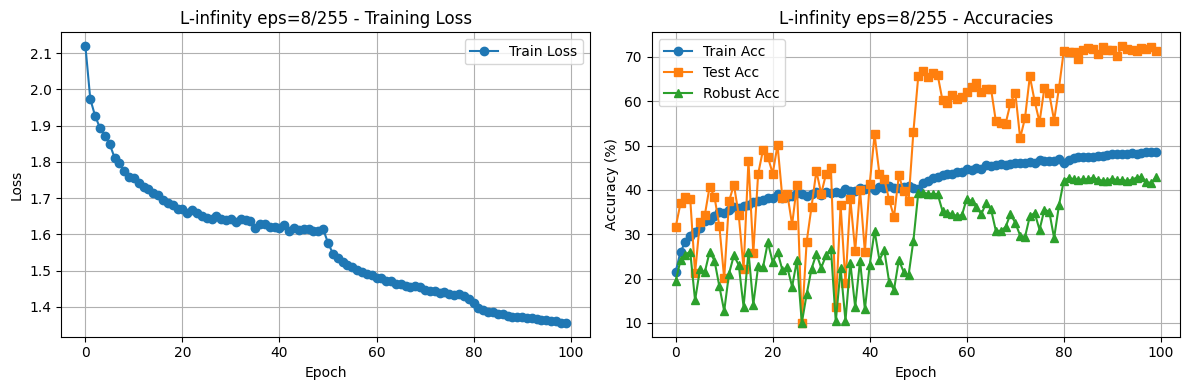

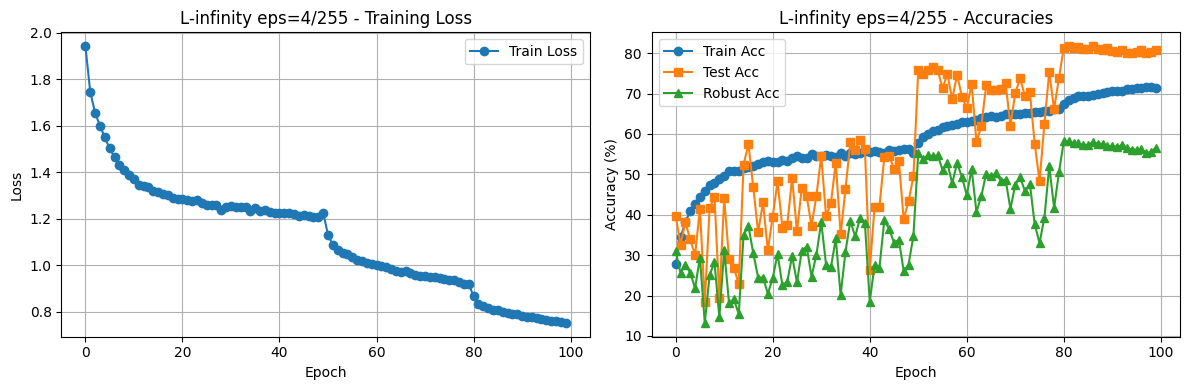

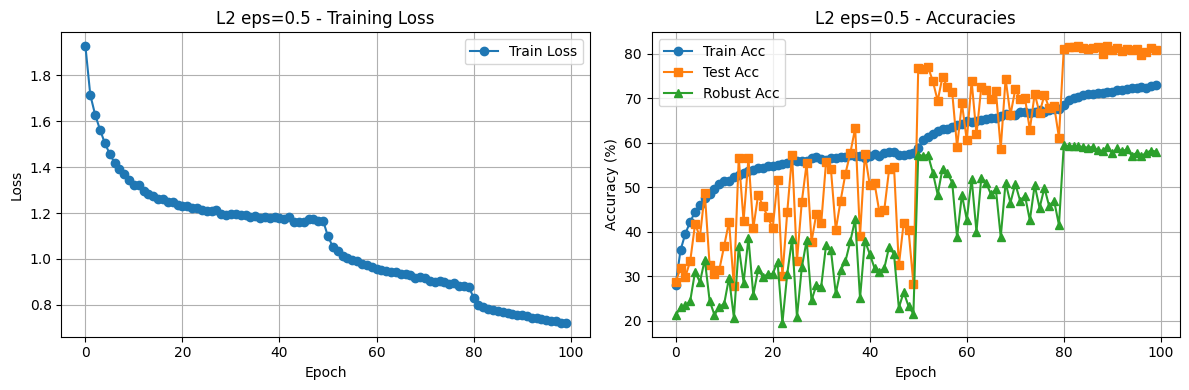

In [16]:
# Plot training curves
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    axes[0].plot(history['train_loss'], marker='o', label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Training Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    axes[1].plot([100*x for x in history['train_acc']], marker='o', label='Train Acc')
    axes[1].plot([100*x for x in history['test_acc']], marker='s', label='Test Acc')
    axes[1].plot([100*x for x in history['robust_acc']], marker='^', label='Robust Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracies')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot all training curves
plot_training_history(history_linf_8, 'L-infinity eps=8/255')
plot_training_history(history_linf_4, 'L-infinity eps=4/255')
plot_training_history(history_l2_05, 'L2 eps=0.5')